In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import javalang
from dataclasses import dataclass
from tqdm.auto import tqdm
from pickle_cache import PickleCache
from javalang import tree
from pprint import pprint
import textwrap
import copy
from iterextras import par_for, unzip
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
sns.set()

In [3]:
pcache = PickleCache('.pcache')

In [4]:
DATA_DIR = '../data/cs106a/CheckerboardKarel_anonymized'
STUDENTS = os.listdir(DATA_DIR)

In [5]:
@dataclass
class Program:
    source: str
    ast: tree.CompilationUnit

In [6]:
def get_solutions():
    solutions = {}
    def load_student_programs(student):
        files = sorted(os.listdir(f'{DATA_DIR}/{student}'))
        programs = []
        for f in files:
            try:
                source = open(f'{DATA_DIR}/{student}/{f}').read()
                ast = javalang.parse.parse(source)
                programs.append(Program(ast=ast, source=source))
            except (UnicodeDecodeError, javalang.parser.JavaSyntaxError, javalang.tokenizer.LexerError):
                pass
        return programs
    progs = par_for(load_student_programs, STUDENTS)
    return {k: v for k, v in zip(STUDENTS, progs)}

solutions = pcache.get('solutions', get_solutions)

In [41]:
def compute_features(student):
    progs = solutions[student]
    df = []
    for i, prog in enumerate(progs):
        try:
            methods = get_methods(prog)
        except Exception:
            continue
        if len(methods) == 0:
            continue
        max_size = np.max([tree_size(method) for method in methods.values()])
        df.append({
            'student': student, 
            'time': i,
            'max_size': max_size,
            'num_methods': len(methods)
        })
    return df
            
features = par_for(compute_features, STUDENTS)

In [42]:
feature_df = pd.DataFrame([f for l in features for f in l])

In [48]:
def plot_progress(students, lines=None):
    inverse_index = {s: i for i, s in enumerate(students)}
    df = feature_df[feature_df.student.isin(students)]
    g = sns.FacetGrid(data=df, col_order=students, col='student', col_wrap=4, sharex=False)
    def plot(data, **kwargs):
        ax = plt.gca()
        ax2 = ax.twinx()
        ax2.set_ylim(0, 10)
        sns.lineplot(data=data, x='time', y='max_size', color='r', ax=ax)
        sns.lineplot(data=data, x='time', y='num_methods', color='g', ax=ax2)
        if lines is not None:
            ax.axvline(lines[inverse_index[data.student.iloc[0]]], color='b')
    g.map_dataframe(plot)    

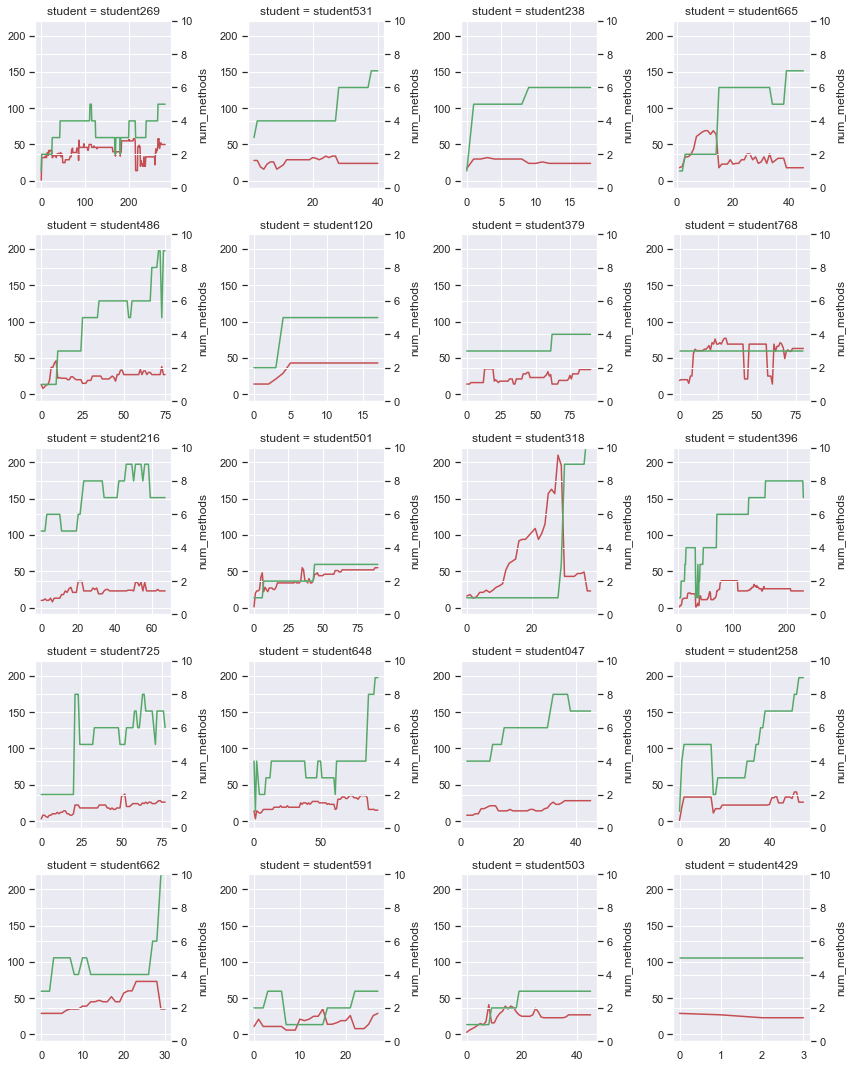

In [44]:
from random import sample
rand_students = sample(STUDENTS, k=20)
#rand_students = ['student043', 'student288', 'student395', 'student409']
plot_progress(rand_students)

In [50]:
all_features = []
all_features_time = []
all_students = []
for student in tqdm(STUDENTS):
    student_df = feature_df[feature_df.student == student]
    max_diffs = np.diff(student_df.max_size)
    method_diffs = np.diff(student_df.num_methods)
    if len(max_diffs) > 0:
        all_students.append(student)
        feature = -max_diffs * method_diffs
        i = np.argmax(feature)
        all_features_time.append(i)
        all_features.append(feature[i])
        
all_students = np.array(all_students)        
all_features = np.array(all_features)
all_features_time = np.array(all_features_time)

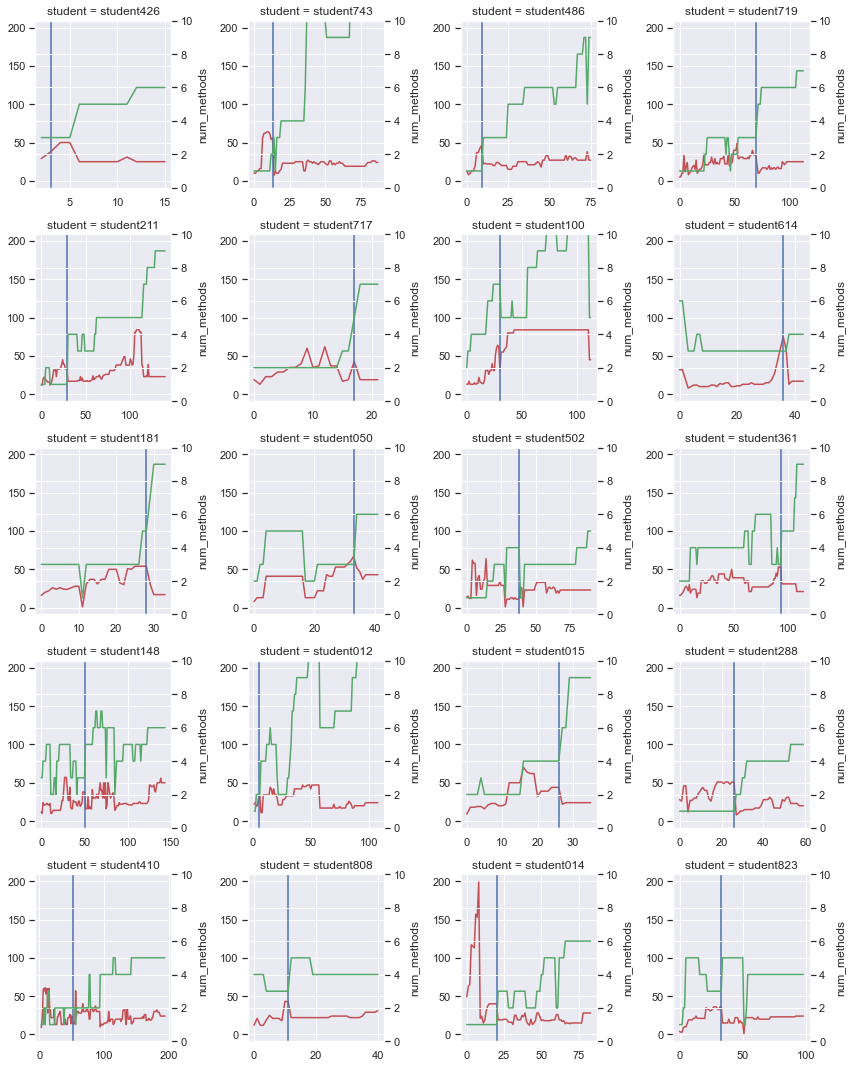

In [72]:
highest_delta = np.argsort(all_features)[::-1]
plot_progress(all_students[highest_delta[100:120]], lines=all_features_time[highest_delta[100:120]])

In [65]:
from ipywidgets import Button
from IPython.display import clear_output, display

def paginate(l, f):
    page = 0
    
    def update():
        clear_output()
        prev_btn = Button(description='Prev')
        next_btn = Button(description='Next')
        prev_btn.on_click(prev_page)
        next_btn.on_click(next_page)
        display(prev_btn)
        display(next_btn)
        f(l[page])
    
    def prev_page(_):
        nonlocal page
        page = max(page - 1, 0)
        update()
    
    def next_page(_):
        nonlocal page
        page = min(page + 1, len(l) - 1)                
        update()
        
    update()

In [71]:
highest_delta = np.argsort(all_features)[::-1]
l = [
    (student, solutions[student][time].source, solutions[student][time+1].source)
    for student, time in zip(all_students[highest_delta[100:120]], all_features_time[highest_delta[100:120]])
]
paginate(l, lambda t: print('\n\n'.join(t)))

Button(description='Prev', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

student486

/*
 * File: CheckerboardKarel.java
 * ----------------------------
 * When you finish writing it, the CheckerboardKarel class should draw
 * a checkerboard using beepers, as described in Assignment 1.  You
 * should make sure that your program works for all of the sample
 * worlds supplied in the starter folder.
 */

import stanford.karel.*;

public class CheckerboardKarel extends SuperKarel {

	// You fill in this part
	public void run () {
		while (frontIsClear()) {
			while (frontIsClear()) {
				putBeeper();
				move();
				if (frontIsClear()) {
					move();
				}
			}
			turnLeft();
			if (frontIsClear()) {
				move();
				turnLeft();
			}
			
			
			while (frontIsClear()) {
				putBeeper();
				move();
				if (frontIsClear()) {
					move();			
				}
			}
			turnRight();
			if (frontIsClear()) {
				move();
				turnRight();
			}
		}
	}
}


/*
 * File: CheckerboardKarel.java
 * ----------------------------
 * When you finish writing it, the CheckerboardKarel class shoul

In [13]:
"""
late decomp examples:
043 288? 395 409

tried decomp but gave up:
069 231 687
"""

# bad decomp examples:
# 281, 180

"""
notes

* high level strategies
 - do one row, move, then do another row, move
"""

'\nnotes\n\n* high level strategies\n - do one row, move, then do another row, move\n'

In [14]:
# import traceback

# inlined = {}    
# fail = 0
# for student, soln in tqdm(list(solutions.items())):
#     try:
#         methods = get_methods(soln)
#         start = copy.deepcopy(methods['run'])
#         inlined[student] = fun_to_string(Inline(methods).visit(start))
# #     except RecursionError:
# #         pass
#     except Exception:
#         fail += 1
